# Train a transformer-based model

In [1]:
!pip install transformers
!pip install datasets
!pip install accelerate==0.31.0
import accelerate
from datasets import load_dataset
from datasets import load_metric
import numpy as np
from datasets import Dataset
from datasets import DatasetDict
import pandas as pd
from typing import Dict
import torch
from transformers import DataCollatorWithPadding
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, EvalPrediction, Trainer, TrainingArguments, set_seed

### Model Parameters
language_model_name = "bert-base-cased"

### Training Argurments
batch_size = 32
# optim
learning_rate = 1e-4
weight_decay = 0.001
# training
epochs = 3
device = "cuda" if torch.cuda.is_available() else "cpu"
set_seed(42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [2]:
dataset = load_dataset("tommasobonomo/sem_augmented_fever_nli")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/51086 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2288 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2287 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'label', 'wsd', 'srl'],
        num_rows: 51086
    })
    validation: Dataset({
        features: ['id', 'premise', 'hypothesis', 'label', 'wsd', 'srl'],
        num_rows: 2288
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'label', 'wsd', 'srl'],
        num_rows: 2287
    })
})

In [ ]:
## Let's see an example...
i=1
print(f"Premise: {dataset['train']['premise'][i]}")
print(f"Hypothesis: {dataset['train']['hypothesis'][i]}")
print(f"Label: {'Entailment' if dataset['train']['label'][i] == 'ENTAILMENT' else 'Contradiction' if dataset['train']['label'][i] == 'CONTRADICTION'  else 'Neutral'}")

Premise: Boston Celtics . The Celtics play their home games at the TD Garden , which they share with the National Hockey League ( NHL ) 's Boston Bruins .
Hypothesis: The Boston Celtics play their home games at TD Garden.
Label: Entailment


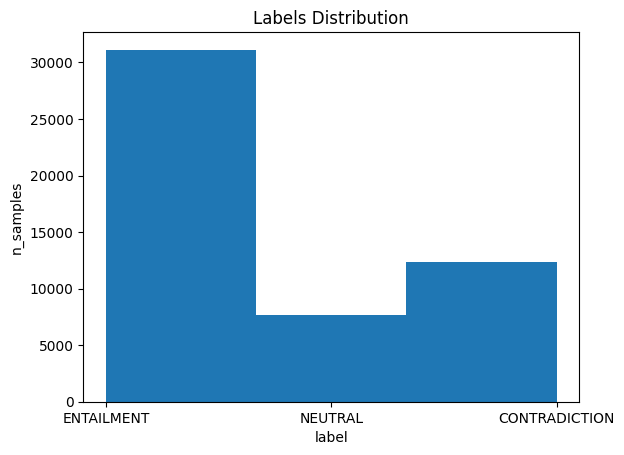

In [3]:
from datasets import ClassLabel
import matplotlib.pyplot as plt
# Plot labels distribution
data = pd.DataFrame(dataset["train"]["label"], columns=["label"])
labels = data["label"].unique().tolist()
ClassLabels = ClassLabel(num_classes=len(labels), names=labels)
plt.hist(data['label'], bins=len(labels))
plt.xticks(range(len(labels)), labels)
plt.xlabel('label')
plt.ylabel('n_samples')
plt.title('Labels Distribution')
plt.show()

In [4]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

load_accuracy = load_metric("accuracy")
load_f1 = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels, average='weighted')["f1"]

    # confusion matrix
    cm = confusion_matrix(labels, predictions, normalize='all')
    cm = [[round(val, 3) for val in row] for row in cm]
    cm = np.array(cm)
    label_map = {"ENTAILMENT": 0, "NEUTRAL": 1, "CONTRADICTION": 2}
    label_names = list(label_map.keys())
    cm = pd.DataFrame(cm, columns=label_names, index=label_names)

    # precision and recall
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')

    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall, "norm_conf_matrix": cm}


<ipython-input-4-ddffd8826a22>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for f1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/f1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [6]:
## Initialize the model
model = AutoModelForSequenceClassification.from_pretrained(language_model_name, ignore_mismatched_sizes=True,
                                                           output_attentions=False, output_hidden_states=False,
                                                           num_labels=3) # number of the classes (3)
tokenizer = AutoTokenizer.from_pretrained(language_model_name)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [12]:
def tokenize_function(examples):
    # Extract labels
    labels = examples.pop("label")
    if isinstance(labels[0], list):
        labels = [label[0] for label in labels]

    # Map string labels to numerical categories
    label_map = {"ENTAILMENT": 0, "NEUTRAL": 1, "CONTRADICTION": 2}  # Define mapping
    numerical_labels = [label_map[label] for label in labels]  # Apply mapping

    tokenized_output = tokenizer(
        examples["premise"],
        examples["hypothesis"],
        truncation=True,
        padding='max_length',
        max_length=512,
        return_tensors="pt"
    )
    tokenized_output['labels'] = torch.tensor(numerical_labels)  # Use numerical labels
    return tokenized_output

In [14]:
# Tokenize the dataset ...
print("Tokenize the dataset ...")
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Tokenize the dataset ...


Map:   0%|          | 0/51086 [00:00<?, ? examples/s]

Map:   0%|          | 0/2288 [00:00<?, ? examples/s]

Map:   0%|          | 0/2287 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(
    output_dir="training_dir",
    num_train_epochs=3,                      # total number of training epochs
    per_device_train_batch_size=batch_size,       # batch size per device during training (32)
    warmup_steps=500,                             # number of warmup steps for learning rate scheduler
    weight_decay=weight_decay,                    # strength of weight decay
    save_strategy="no",
    learning_rate=learning_rate,
    logging_steps=1000,
    evaluation_strategy="steps",
    eval_steps=1000
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_datasets["train"],
   eval_dataset=tokenized_datasets["validation"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
# Let's Train ...
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Norm Conf Matrix
1000,0.555100,0.734057,0.719406,0.712403,0.718669,0.719406,ENTAILMENT NEUTRAL CONTRADICTION ENTAILMENT 0.322 0.024 0.013 NEUTRAL 0.088 0.161 0.054 CONTRADICTION 0.042 0.060 0.236
2000,0.422000,0.791423,0.720717,0.707238,0.723032,0.720717,ENTAILMENT NEUTRAL CONTRADICTION ENTAILMENT 0.327 0.017 0.015 NEUTRAL 0.094 0.136 0.073 CONTRADICTION 0.046 0.035 0.258
3000,0.353900,0.750876,0.734266,0.724699,0.732877,0.734266,ENTAILMENT NEUTRAL CONTRADICTION ENTAILMENT 0.325 0.021 0.014 NEUTRAL 0.087 0.152 0.064 CONTRADICTION 0.038 0.043 0.258
4000,0.254700,0.868116,0.735140,0.728653,0.734596,0.735140,ENTAILMENT NEUTRAL CONTRADICTION ENTAILMENT 0.323 0.028 0.008 NEUTRAL 0.083 0.164 0.056 CONTRADICTION 0.042 0.049 0.248


Trainer is attempting to log a value of "               ENTAILMENT  NEUTRAL  CONTRADICTION
ENTAILMENT          0.322    0.024          0.013
NEUTRAL             0.088    0.161          0.054
CONTRADICTION       0.042    0.060          0.236" of type <class 'pandas.core.frame.DataFrame'> for key "eval/norm_conf_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "               ENTAILMENT  NEUTRAL  CONTRADICTION
ENTAILMENT          0.327    0.017          0.015
NEUTRAL             0.094    0.136          0.073
CONTRADICTION       0.046    0.035          0.258" of type <class 'pandas.core.frame.DataFrame'> for key "eval/norm_conf_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "               ENTAILMENT  NEUTRAL  CONTRADICTION
ENTAILMENT          0.325    0.021          0.014
N

TrainOutput(global_step=4791, training_loss=0.3658618803587619, metrics={'train_runtime': 3028.186, 'train_samples_per_second': 50.61, 'train_steps_per_second': 1.582, 'total_flos': 4.032423617415782e+16, 'train_loss': 0.3658618803587619, 'epoch': 3.0})

In [ ]:
# Evaluate the model ...
trainer.evaluate()

Trainer is attempting to log a value of "               ENTAILMENT  NEUTRAL  CONTRADICTION
ENTAILMENT          0.326    0.024          0.009
NEUTRAL             0.087    0.161          0.054
CONTRADICTION       0.044    0.052          0.243" of type <class 'pandas.core.frame.DataFrame'> for key "eval/norm_conf_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.9280675053596497,
 'eval_accuracy': 0.7307692307692307,
 'eval_f1': 0.7233763830702434,
 'eval_precision': 0.7313463644438333,
 'eval_recall': 0.7307692307692307,
 'eval_norm_conf_matrix':                ENTAILMENT  NEUTRAL  CONTRADICTION
 ENTAILMENT          0.326    0.024          0.009
 NEUTRAL             0.087    0.161          0.054
 CONTRADICTION       0.044    0.052          0.243,
 'eval_runtime': 16.9283,
 'eval_samples_per_second': 135.159,
 'eval_steps_per_second': 16.895,
 'epoch': 3.0}

In [ ]:
trainer.evaluate(tokenized_datasets["test"])

Trainer is attempting to log a value of "               ENTAILMENT  NEUTRAL  CONTRADICTION
ENTAILMENT          0.308    0.024          0.014
NEUTRAL             0.083    0.152          0.063
CONTRADICTION       0.042    0.059          0.254" of type <class 'pandas.core.frame.DataFrame'> for key "eval/norm_conf_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.965441882610321,
 'eval_accuracy': 0.7140358548316572,
 'eval_f1': 0.7064875511878119,
 'eval_precision': 0.7113310048303882,
 'eval_recall': 0.7140358548316572,
 'eval_norm_conf_matrix':                ENTAILMENT  NEUTRAL  CONTRADICTION
 ENTAILMENT          0.308    0.024          0.014
 NEUTRAL             0.083    0.152          0.063
 CONTRADICTION       0.042    0.059          0.254,
 'eval_runtime': 17.1835,
 'eval_samples_per_second': 133.092,
 'eval_steps_per_second': 16.644,
 'epoch': 3.0}

# Adversarial Test

In [5]:
adversarial_test = load_dataset("iperbole/adversarial_fever_nli")

Generating test split:   0%|          | 0/337 [00:00<?, ? examples/s]

In [15]:
tokenized_adversarial_test= adversarial_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/337 [00:00<?, ? examples/s]

In [ ]:
trainer.evaluate(tokenized_adversarial_test)

Trainer is attempting to log a value of "               ENTAILMENT  NEUTRAL  CONTRADICTION
ENTAILMENT          0.172    0.047          0.110
NEUTRAL             0.092    0.202          0.033
CONTRADICTION       0.110    0.071          0.163" of type <class 'pandas.core.frame.DataFrame'> for key "eval/test_norm_conf_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_test_loss': 1.5155690908432007,
 'eval_test_accuracy': 0.5370919881305638,
 'eval_test_f1': 0.5377383006460185,
 'eval_test_precision': 0.5409384122472193,
 'eval_test_recall': 0.5370919881305638,
 'eval_test_norm_conf_matrix':                ENTAILMENT  NEUTRAL  CONTRADICTION
 ENTAILMENT          0.172    0.047          0.110
 NEUTRAL             0.092    0.202          0.033
 CONTRADICTION       0.110    0.071          0.163,
 'eval_test_runtime': 2.5937,
 'eval_test_samples_per_second': 129.929,
 'eval_test_steps_per_second': 16.578,
 'epoch': 3.0}

# Pipeline for generating adversarial training set

In [6]:
!pip3 install nltk==3.6.5
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
import random
import json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.2 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [7]:
# @title adv_set #1 : in premessa sinonimi di verbi e iponimi di nomi, in ipotesi sinonimi di verbi e ipernomi di nomi

def hyponym(word):                         ### cerca iponimo di un nome
  for syn in wn.synsets(word, pos=wn.NOUN):
    hyponyms = syn.hyponyms()
    if hyponyms:
      hyponym = random.choice(hyponyms)
      return random.choice(hyponym.lemma_names()) if hyponyms else None

def hypernym(word):                         ### cerca iperonimo di un nome
  for syn in wn.synsets(word, pos=wn.NOUN):
    hypernyms = syn.hypernyms()
    if hypernyms:
      hypernym = random.choice(hypernyms)
      return random.choice(hypernym.lemma_names()) if hypernyms else None

def synonym(word):                         ### cerca sinonimo di un verbo
  for syn in wn.synsets(word, pos=wn.VERB):
    synonyms = syn.lemma_names()
    if synonyms:
      return random.choice(synonyms) if synonyms else None

def generate_new_sample(sample):             #### genera nuovi samples sostituendo nomi in premessa con iponomi, nomi in ipotesi con ipernomi e verbi con sinonimi
    new_sample = sample.copy()
    wsd_p = new_sample['wsd']['premise']
    wsd_h = new_sample['wsd']['hypothesis']
    for word in wsd_p:
        if word['pos'] == 'NOUN' :
            new_word = hyponym(word['lemma'])
            if new_word:
                word['text'] = new_word
            break
        if word['pos'] == 'VERB' :
            new_word = synonym(word['lemma'])
            if new_word:
                word['text'] = new_word
            break
    for word in wsd_h:
        if word['pos'] == 'NOUN' :
            new_word = hypernym(word['lemma'])
            if new_word:
                word['text'] = new_word
            break
        if word['pos'] == 'VERB' :
            new_word = synonym(word['lemma'])
            if new_word:
                word['text'] = new_word
            break
    new_sample['premise'] = ' '.join([word['text'] for word in wsd_p])
    new_sample['hypothesis'] = ' '.join([word['text'] for word in wsd_h])
    del new_sample['wsd'],new_sample['id'],new_sample['srl']
    return new_sample

def generate_adversarial_set(dataset, max_samples=8000):
    new_samples = []
    for sample in dataset:
        new_sample= generate_new_sample(sample)
        if new_sample['premise'] != sample['premise'] and new_sample['hypothesis'] != sample['hypothesis']:
         new_samples.append(new_sample)
         if len(new_samples) >= max_samples:
                break
    return new_samples

def save_samples_to_file(samples, filename):
    with open(filename, 'w') as f:
        for sample in samples:
            json.dump(sample, f)
            f.write('\n')

adversarial_samples = generate_adversarial_set(dataset['train'])
save_samples_to_file(adversarial_samples, 'adversarial_samples.json')

In [8]:
# @title adv_set #2 : in ipotesi contrario di nomi e aggettivi (con cambio label)

def antonym(word):                         ###cerca contrario di una parola
  for syn in wn.synsets(word):
    for lemma in syn.lemmas():
      if lemma.antonyms():
        antonyms = lemma.antonyms()
        return antonyms[0].name() if antonyms else None

def generate_new_sample2(sample):             #### genera nuova ipotesi sostituendo nomi e agg con il loro contrario
    new_sample = sample.copy()
    wsd_h = new_sample['wsd']['hypothesis']
    change = False
    for word in wsd_h:
        if word['pos'] == 'NOUN' or word['pos'] == 'ADJ' :
            new_word = antonym(word['lemma'])
            if new_word:
                word['text'] = new_word
                change = True
            break
    new_sample['hypothesis'] = ' '.join([word['text'] for word in wsd_h])
    if change == True:                                                                ###scambia labels se trovato almeno un contrario
        if new_sample['label'] == 'ENTAILMENT':
          new_sample['label'] = 'CONTRADICTION'
        elif new_sample['label'] == 'CONTRADICTION':
          new_sample['label'] = 'ENTAILMENT'

    del new_sample['wsd'],new_sample['id'],new_sample['srl']
    return new_sample, change

def generate_adversarial_set2(dataset, max_samples=5000):
    new_samples = []
    for sample in dataset:
        new_sample, change = generate_new_sample2(sample)
        if change == True:
            new_samples.append(new_sample)
            if len(new_samples) >= max_samples:
                break
    return new_samples

def save_samples_to_file(samples, filename):
    with open(filename, 'w') as f:
        for sample in samples:
            json.dump(sample, f)
            f.write('\n')

adversarial_samples2 = generate_adversarial_set2(dataset['train'])
save_samples_to_file(adversarial_samples2, 'adversarial_samples2.json')

In [9]:
# @title adv_set #3 : in ipotesi swap tra agent e patient (con cambio label)

def generate_new_sample3(sample):
    new_sample = sample.copy()
    srl_h = new_sample['srl']['hypothesis']
    augmented_hypothesis = None
    swap = False
    tokens_text = [token['rawText'] for token in srl_h['tokens']]
    for verb_info in srl_h['annotations']:
            if 'verbatlas' in verb_info:
                roles = verb_info['verbatlas']['roles']
                agent_span = None
                patient_span = None
                for role_info in roles:
                    if role_info['role'] == 'Agent':
                        agent_span = role_info['span']
                    elif role_info['role'] == 'Patient':
                        patient_span = role_info['span']
                if agent_span is not None and patient_span is not None:
                    agent_start, agent_end = agent_span
                    patient_start, patient_end = patient_span
                    if agent_start > patient_start:
                        agent_span, patient_span = patient_span, agent_span
                        agent_start, agent_end = agent_span
                        patient_start, patient_end = patient_span
                    agent_tokens = tokens_text[agent_start:agent_end]
                    patient_tokens = tokens_text[patient_start:patient_end]
                    agent_text = ' '.join(agent_tokens)
                    patient_text = ' '.join(patient_tokens)
                    # Build the augmented hypothesis by swapping agent and patient
                    new_tokens = tokens_text[:agent_start] + [patient_text] + tokens_text[agent_end:patient_start] + [agent_text] + tokens_text[patient_end:]
                    swap=True
                    augmented_hypothesis = ' '.join(new_tokens)
                    break
    new_sample['hypothesis'] = augmented_hypothesis
    if swap == True:
        if sample['label'] == 'ENTAILMENT':
          new_sample['label'] = 'CONTRADICTION'
        elif sample['label'] == 'CONTRADICTION':
          new_sample['label'] = 'NEUTRAL'
    del new_sample['wsd'],new_sample['id'],new_sample['srl']
    return new_sample , swap

def generate_adversarial_set3(dataset, max_samples=50000):    ### max 2500 samples con ag-pat
    new_samples = []
    for sample in dataset:
        new_sample , swap = generate_new_sample3(sample)
        if swap == True:
            new_samples.append(new_sample)
            if len(new_samples) >= max_samples:
                break
    return new_samples

def save_samples_to_file(samples, filename):
    with open(filename, 'w') as f:
        for sample in samples:
            json.dump(sample, f)
            f.write('\n')

adversarial_samples3 = generate_adversarial_set3(dataset['train'])
save_samples_to_file(adversarial_samples3, 'adversarial_samples3.json')

In [10]:
# @title adv_set #4 : in ipotesi aggiunge "not" dopo lemma = 'be' (con cambio label)

def generate_new_sample4(sample):             #### genera nuova ipotesi aggiungendo NOT in seguito ad ogni forma del verbo 'essere'
    new_sample = sample.copy()
    wsd_h = new_sample['wsd']['hypothesis']
    add_not = False
    if sample['label'] == 'ENTAILMENT':
        for word in wsd_h:
                if word['lemma'] == "be" :
                    word['text'] =  word['text'] + " not"
                    add_not = True
                    break
    new_sample['hypothesis'] = ' '.join([word['text'] for word in wsd_h])
    if add_not == True:                                                                ### scambio labels
        if sample['label'] == 'ENTAILMENT':
            new_sample['label'] = 'CONTRADICTION'
    del new_sample['wsd'],new_sample['id'],new_sample['srl']
    return new_sample, add_not

def generate_adversarial_set4(dataset, max_samples=2500):
    new_samples = []
    for sample in dataset:
        new_sample, add_not = generate_new_sample4(sample)
        if add_not == True:
            new_samples.append(new_sample)
            if len(new_samples) >= max_samples:
                break
    return new_samples

def save_samples_to_file(samples, filename):
    with open(filename, 'w') as f:
        for sample in samples:
            json.dump(sample, f)
            f.write('\n')

adversarial_samples4 = generate_adversarial_set4(dataset['train'])
save_samples_to_file(adversarial_samples4, 'adversarial_samples4.json')

#New training and test

Number of samples in the new train split: 69042


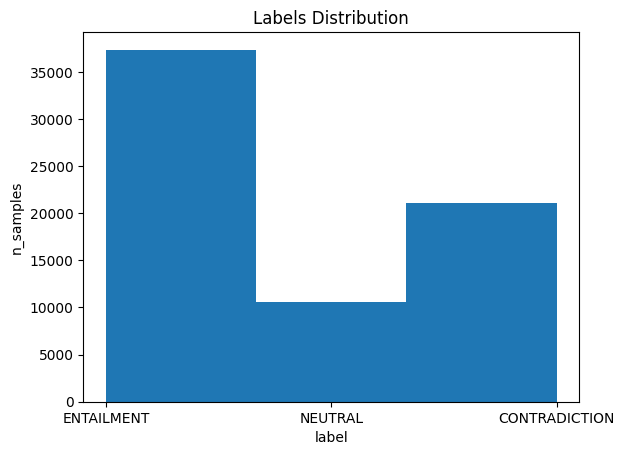

In [11]:
# Load the adversarial samples
with open('adversarial_samples.json', 'r') as f:
    adversarial_samples = [json.loads(line) for line in f]
with open('adversarial_samples2.json', 'r') as f:
    adversarial_samples2 = [json.loads(line) for line in f]
with open('adversarial_samples3.json', 'r') as f:
    adversarial_samples3 = [json.loads(line) for line in f]
with open('adversarial_samples4.json', 'r') as f:
    adversarial_samples4 = [json.loads(line) for line in f]

new_training_set = dataset['train'].to_pandas()
# Add the adversarial samples to the train split
df_adversarial_samples4 = pd.DataFrame(adversarial_samples4)
new_training_set = pd.concat([new_training_set, df_adversarial_samples4], ignore_index=True)
df_adversarial_samples3 = pd.DataFrame(adversarial_samples3)
new_training_set = pd.concat([new_training_set, df_adversarial_samples3], ignore_index=True)
df_adversarial_samples2 = pd.DataFrame(adversarial_samples2)
new_training_set = pd.concat([new_training_set, df_adversarial_samples2], ignore_index=True)
df_adversarial_samples = pd.DataFrame(adversarial_samples)
new_training_set = pd.concat([new_training_set, df_adversarial_samples], ignore_index=True)
new_training_set = Dataset.from_pandas(new_training_set)
print(f"Number of samples in the new train split: {len(new_training_set)}")

#print new label distribution
data = pd.DataFrame(new_training_set["label"], columns=["label"])
labels = data["label"].unique().tolist()
ClassLabels = ClassLabel(num_classes=len(labels), names=labels)
plt.hist(data['label'], bins=len(labels))
plt.xticks(range(len(labels)), labels)
plt.xlabel('label')
plt.ylabel('n_samples')
plt.title('Labels Distribution')
plt.show()

In [13]:
language_model_name="bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(language_model_name, ignore_mismatched_sizes=True,
                                                           output_attentions=False, output_hidden_states=False,
                                                           num_labels=3) # number of the classes (3)
tokenizer = AutoTokenizer.from_pretrained(language_model_name)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tok_new_training_set = new_training_set.map(tokenize_function, batched=True)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/69042 [00:00<?, ? examples/s]

In [16]:
training_args = TrainingArguments(
    output_dir="training_dir2",
    num_train_epochs=3,                      # total number of training epochs
    per_device_train_batch_size=32,       # batch size per device during training
    warmup_steps=500,
    weight_decay=weight_decay,
    save_strategy="no",
    learning_rate=learning_rate,
    logging_steps=1500,
    evaluation_strategy="steps",
    eval_steps=1500
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tok_new_training_set,  # Use the updated training set with tokenized inputs
   eval_dataset=tokenized_datasets["validation"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Norm Conf Matrix
1500,0.583500,0.827773,0.700612,0.694438,0.714947,0.700612,ENTAILMENT NEUTRAL CONTRADICTION ENTAILMENT 0.326 0.024 0.008 NEUTRAL 0.094 0.178 0.031 CONTRADICTION 0.052 0.090 0.196
3000,0.392500,0.804217,0.724213,0.715896,0.728967,0.724213,ENTAILMENT NEUTRAL CONTRADICTION ENTAILMENT 0.334 0.017 0.007 NEUTRAL 0.092 0.161 0.049 CONTRADICTION 0.053 0.056 0.229
4500,0.306300,0.990927,0.722902,0.717819,0.721086,0.722902,ENTAILMENT NEUTRAL CONTRADICTION ENTAILMENT 0.317 0.027 0.014 NEUTRAL 0.077 0.171 0.054 CONTRADICTION 0.038 0.066 0.235
6000,0.185100,1.006389,0.741259,0.735942,0.741767,0.741259,ENTAILMENT NEUTRAL CONTRADICTION ENTAILMENT 0.326 0.024 0.009 NEUTRAL 0.077 0.176 0.049 CONTRADICTION 0.041 0.059 0.240


Trainer is attempting to log a value of "               ENTAILMENT  NEUTRAL  CONTRADICTION
ENTAILMENT          0.326    0.024          0.008
NEUTRAL             0.094    0.178          0.031
CONTRADICTION       0.052    0.090          0.196" of type <class 'pandas.core.frame.DataFrame'> for key "eval/norm_conf_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "               ENTAILMENT  NEUTRAL  CONTRADICTION
ENTAILMENT          0.334    0.017          0.007
NEUTRAL             0.092    0.161          0.049
CONTRADICTION       0.053    0.056          0.229" of type <class 'pandas.core.frame.DataFrame'> for key "eval/norm_conf_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "               ENTAILMENT  NEUTRAL  CONTRADICTION
ENTAILMENT          0.317    0.027          0.014
N

TrainOutput(global_step=6474, training_loss=0.35232526386156104, metrics={'train_runtime': 4045.2702, 'train_samples_per_second': 51.202, 'train_steps_per_second': 1.6, 'total_flos': 5.449762976032973e+16, 'train_loss': 0.35232526386156104, 'epoch': 3.0})

In [17]:
trainer.evaluate(tokenized_datasets["test"])

Trainer is attempting to log a value of "               ENTAILMENT  NEUTRAL  CONTRADICTION
ENTAILMENT          0.307    0.023          0.016
NEUTRAL             0.084    0.149          0.066
CONTRADICTION       0.042    0.059          0.254" of type <class 'pandas.core.frame.DataFrame'> for key "eval/norm_conf_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 1.0982695817947388,
 'eval_accuracy': 0.7105378224748579,
 'eval_f1': 0.7024521074828041,
 'eval_precision': 0.7070318018099618,
 'eval_recall': 0.7105378224748579,
 'eval_norm_conf_matrix':                ENTAILMENT  NEUTRAL  CONTRADICTION
 ENTAILMENT          0.307    0.023          0.016
 NEUTRAL             0.084    0.149          0.066
 CONTRADICTION       0.042    0.059          0.254,
 'eval_runtime': 16.6139,
 'eval_samples_per_second': 137.656,
 'eval_steps_per_second': 17.215,
 'epoch': 3.0}

In [18]:
trainer.evaluate(tokenized_adversarial_test)

Trainer is attempting to log a value of "               ENTAILMENT  NEUTRAL  CONTRADICTION
ENTAILMENT          0.166    0.056          0.107
NEUTRAL             0.083    0.199          0.045
CONTRADICTION       0.098    0.047          0.199" of type <class 'pandas.core.frame.DataFrame'> for key "eval/test_norm_conf_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_test_loss': 1.587912678718567,
 'eval_test_accuracy': 0.5637982195845698,
 'eval_test_f1': 0.5652283919988622,
 'eval_test_precision': 0.5675000411532655,
 'eval_test_recall': 0.5637982195845698,
 'eval_test_norm_conf_matrix':                ENTAILMENT  NEUTRAL  CONTRADICTION
 ENTAILMENT          0.166    0.056          0.107
 NEUTRAL             0.083    0.199          0.045
 CONTRADICTION       0.098    0.047          0.199,
 'eval_test_runtime': 2.5191,
 'eval_test_samples_per_second': 133.78,
 'eval_test_steps_per_second': 17.07,
 'epoch': 3.0}